In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten,Activation
import seaborn as sb
import deepdish as dd
import seaborn as sns

seed = 42
np.random.seed(seed=seed)


data_setting = 'rawflt'
nb_classes = 2
splitting = 'custom'
if data_setting.startswith('raw'):
    model_setting = 'dl4tsc_inc'#'dl4tsc_inc'#'conv1d'
else:
    model_setting = 'DenseNet121'

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/pyt

### data collecting

In [2]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
0    14979
1    13617
dtype: int64

val: 
0    4971
1    4561
dtype: int64

test: 
0    18260
1    12337
dtype: int64


## Loading model

In [3]:
TL = False

if TL:
    data = Dataset('Wingbeats')
    dataset = data
    splitting='random'
    modelname = f'{TEMP_DATADIR}/Flies_TL_{data_setting}_{model_setting}_{splitting}.h5'

    flag = ''
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=f'MosquitoNET_{data_setting}_{model_setting}_{splitting}_{flag}')
    using_conv2d = False
    base_model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config
    base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # no need to load mosquito weights, we load directly transfer-learned weights after this "if" statement

    if data_setting == 'rawflt':
        if model_setting=='dl4tsc_inc':
            base_output = base_model.layers[-2].output
            new_output = Dense(nb_classes, activation="softmax")(base_output)
            model = Model(inputs=base_model.inputs, outputs=new_output)
        else:
            model = Sequential()
            for layer in base_model.layers[:-1]: # go through until last layer
                model.add(layer)
            #     print(layer.trainable)
            model.add(Dense(nb_classes, activation='softmax'))
    elif data_setting == 'stftflt':
        base_output = base_model.layers[-2].output
        new_output = Dense(nb_classes, activation="softmax")(base_output)
        model = Model(inputs=base_model.inputs, outputs=new_output)
else:
    
    splitting = 'custom'
    modelname = f'{TEMP_DATADIR}/Flies_{data_setting}_{model_setting}_{splitting}.h5'
    
    traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes).config

    base_output = model.layers[-2].output
    new_output = Dense(1, activation=None)(base_output)
    new_output2 = Activation('sigmoid')(new_output)
    model = Model(inputs=model.inputs, outputs=new_output2)

print(f"Model name: {modelname}")
model.load_weights(modelname)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model name: /home/kalfasyan/projects/wingbeat_frequencies/temp_data//Flies_rawflt_dl4tsc_inc_custom.h5


In [4]:
# model.summary()

In [5]:
y_scores = model.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats='', binary_labels=True),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [6]:
model.layers[-5:]

Threshold 0.9 precision: 0.06415340304374695
Precision score: 0.9000324306794227
Recall score: 0.8998135689389641


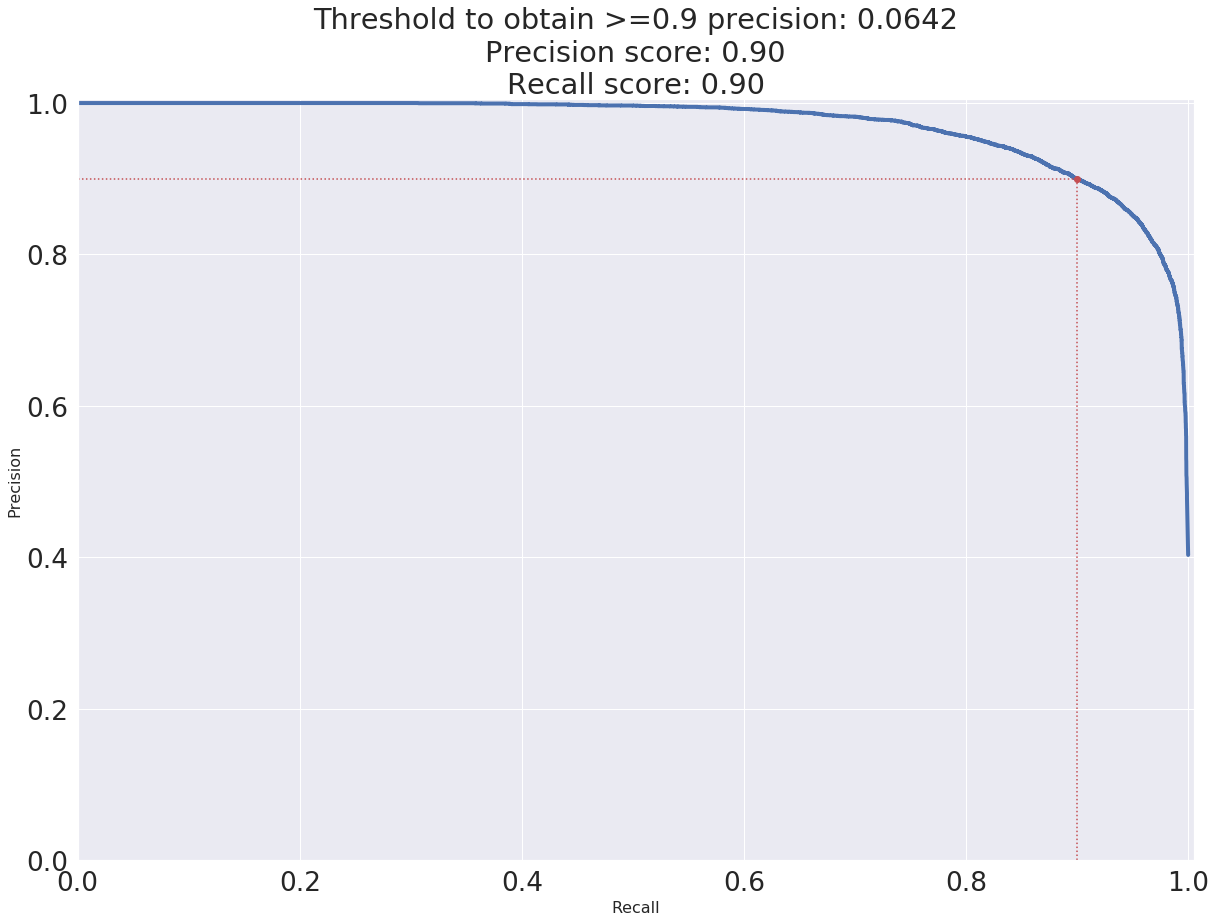

In [7]:
sns.set(font_scale=2.4)

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=4)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.005, 0, 1.005])
    plt.grid(True)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=4, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)     

T = 0.9 # Threshold for Precision

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
recall_T_precision = recalls[np.argmax(precisions >= T)]
threshold_T_precision = thresholds[np.argmax(precisions >= T)]
y_pred = (y_scores >= threshold_T_precision)

print(f"Threshold {T} precision: {threshold_T_precision}")
print(f"Precision score: {precision_score(y_test, y_pred)}")
print(f"Recall score: {recall_score(y_test, y_pred)}")

plt.figure(figsize=(20,14))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_T_precision, recall_T_precision], [0., T], "r:")
plt.plot([0.0, recall_T_precision], [T, T], "r:")
plt.plot([recall_T_precision], [T], "ro")

plt.title(f"Threshold to obtain >={T} precision: {threshold_T_precision:.4f}\nPrecision score: {precision_score(y_test, y_pred):.2f}\nRecall score: {recall_score(y_test, y_pred):.2f}")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_auc{roc_auc_score(y_test, y_pred):.2f}_PRcurve.png', format='png', bbox_inches='tight')

In [8]:
pd.Series(y_test).value_counts()

0    18260
1    12337
dtype: int64

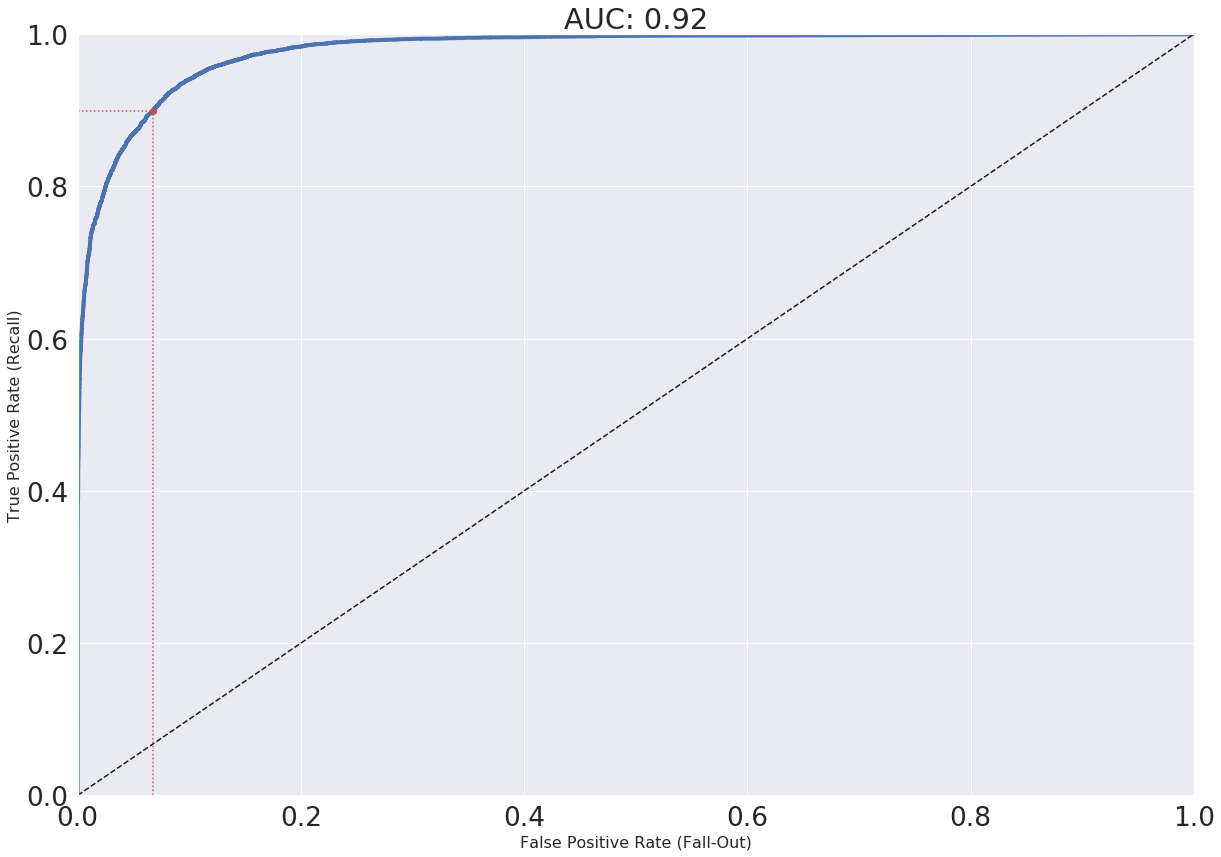

In [9]:
sns.set(font_scale=2.4)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(20,14))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_T_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_T_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_T_precision, recall_T_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_T_precision], "ro")               # Not shown
plt.title(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_auc{roc_auc_score(y_test, y_pred):.2f}_ROC.png', format='png', bbox_inches='tight')

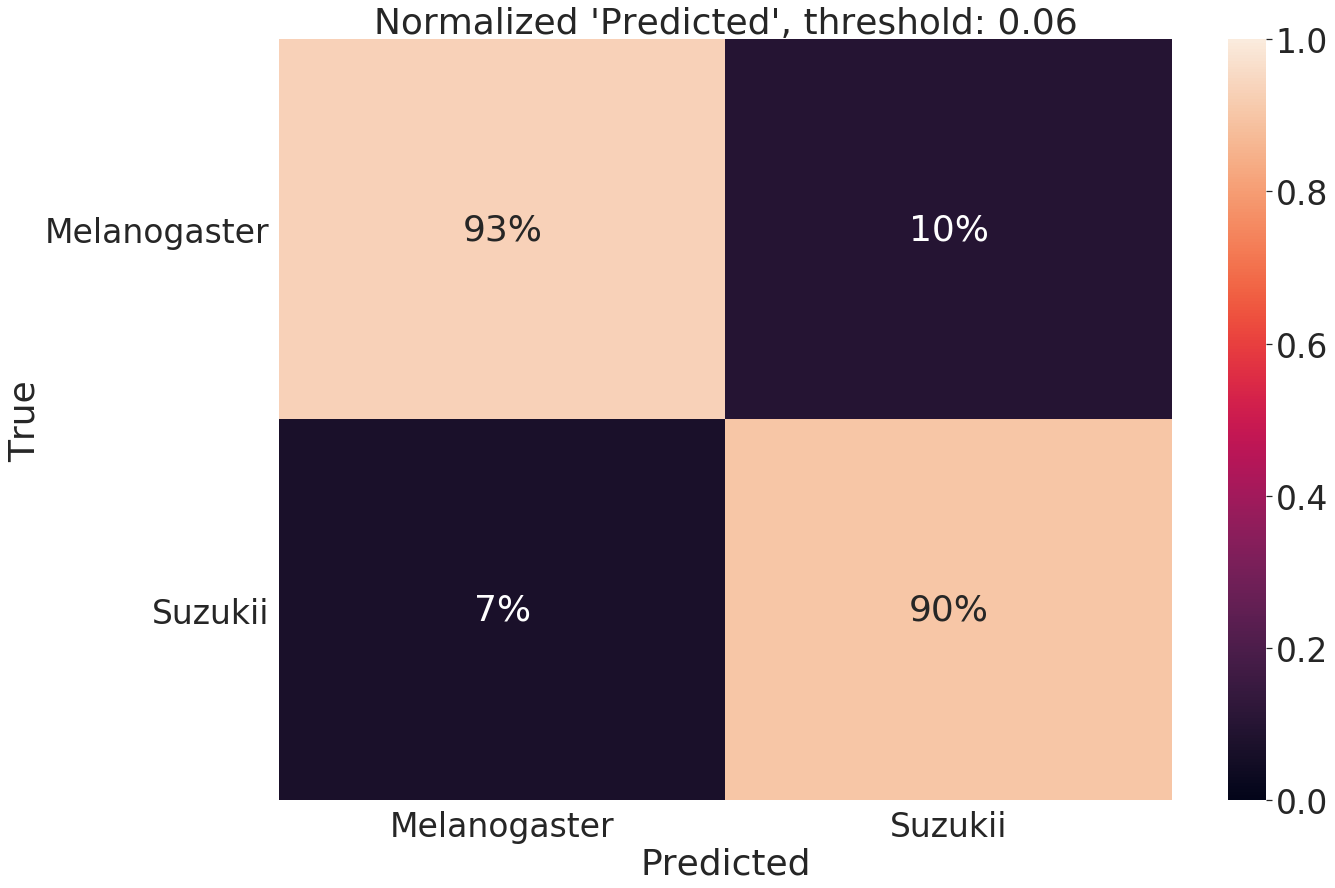

In [10]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred,normalize='pred')
ba = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
sns.set(font_scale=3.)
plt.figure(figsize=(20,14))
lbls = ['Melanogaster', 'Suzukii']
sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=lbls, yticklabels=lbls, vmin=0, vmax=1)
plt.yticks(rotation=0); plt.ylabel("True"); plt.xlabel("Predicted")
plt.title(f"Normalized \'Predicted\', threshold: {threshold_T_precision:.2f}")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}_normalizePred.png', format='png', bbox_inches='tight')

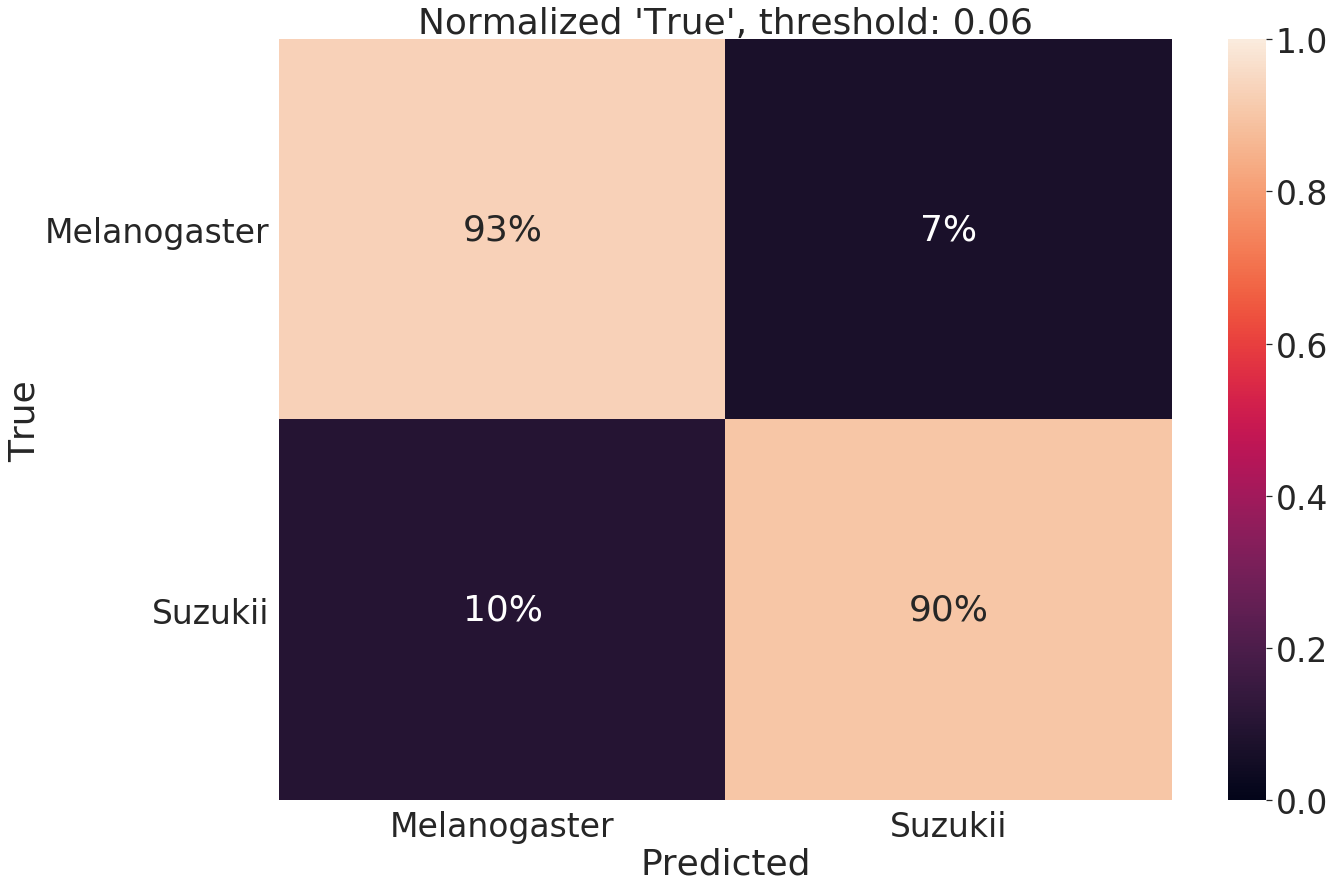

In [11]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred,normalize='true')
ba = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)

sns.set(font_scale=3.)
plt.figure(figsize=(20,14))
sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=lbls, yticklabels=lbls, vmin=0, vmax=1)
plt.title(f"Normalized \'True\', threshold: {threshold_T_precision:.2f}")
plt.yticks(rotation=0); plt.ylabel("True"); plt.xlabel("Predicted")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}_normalizeTrue_{threshold_T_precision}.png', format='png', bbox_inches='tight')

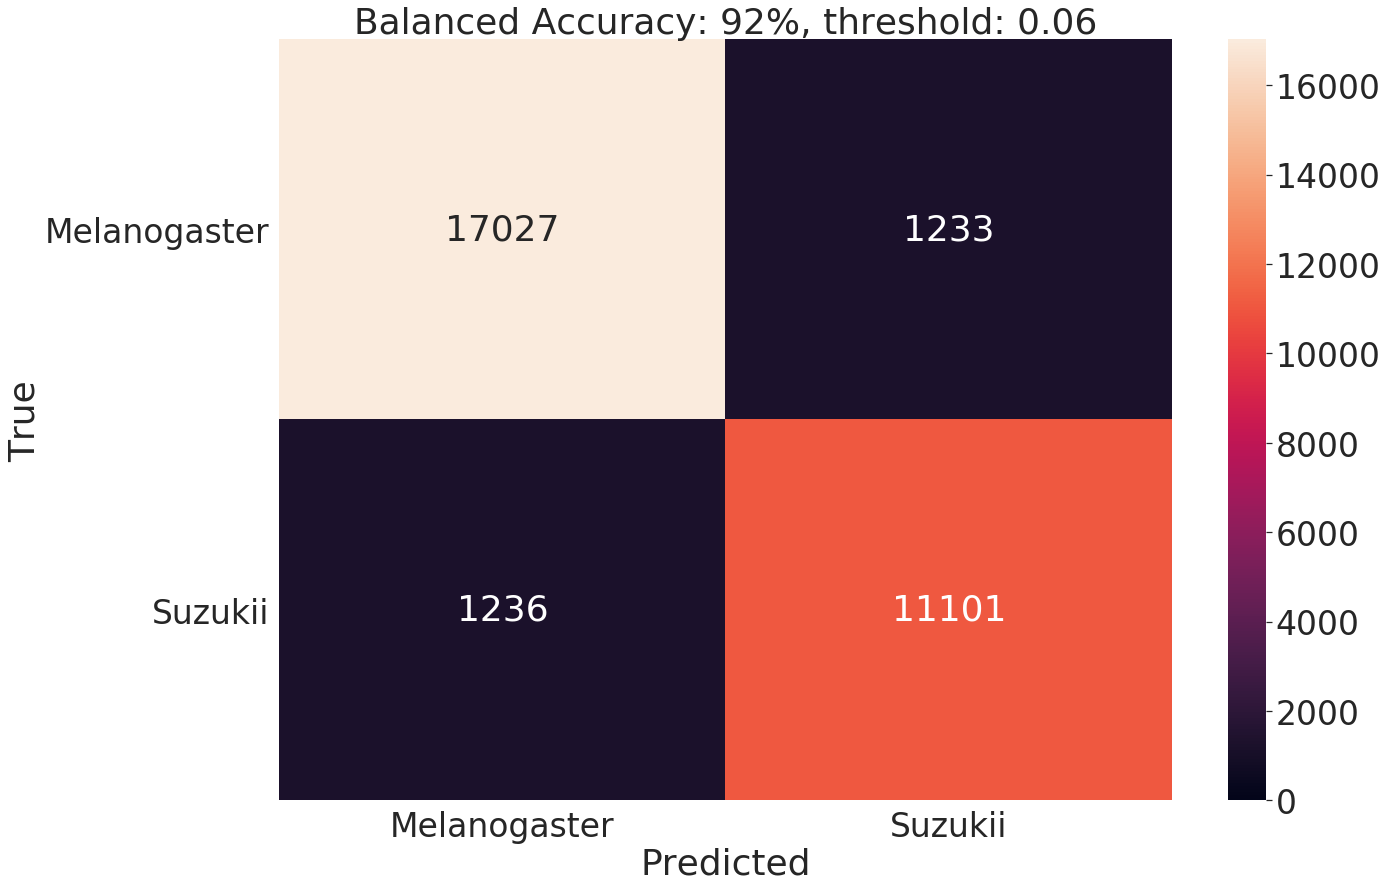

In [12]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred,normalize=None)
sns.set(font_scale=3.)
plt.figure(figsize=(20,14))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=lbls, yticklabels=lbls, vmin=0, vmax=np.max(cm))
plt.yticks(rotation=0); plt.ylabel("True"); plt.xlabel("Predicted")
plt.title(f"Balanced Accuracy: {ba*100:.0f}%, threshold: {threshold_T_precision:.2f}")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}_normalizeNone_{threshold_T_precision}.png', format='png', bbox_inches='tight')

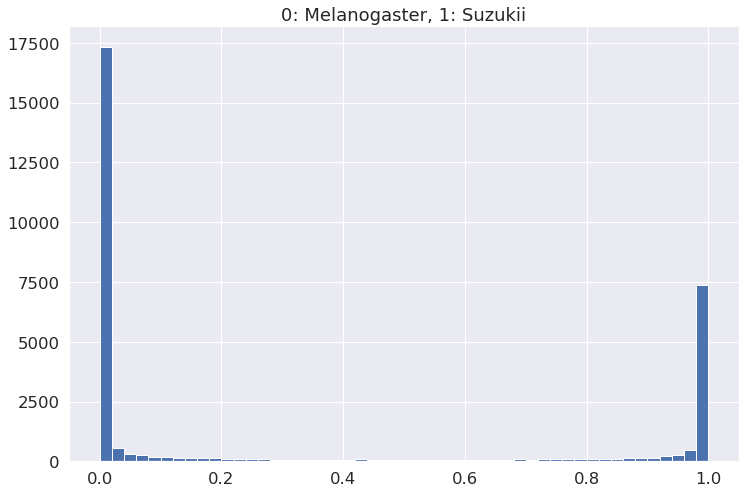

In [13]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.5)
plt.hist(y_scores, bins=50)

plt.title("0: Melanogaster, 1: Suzukii")
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_{ba:.2f}_scores.png', format='png', bbox_inches='tight')

# T-sne and UMAP visualizations

In [50]:
ag = DatasetConfiguration(names=['Aphids_Gnats'])
ag.select_all()
ag.read()

Dataset - Aphids_Gnats - exists: True


In [51]:
ag.fnames.shape

(11005,)

In [52]:
# z = get_clean_wingbeats_multiple_runs(names=ag.fnames.tolist())

In [54]:
ag.clean(threshold=38)
ag.fnames.shape

(478,)

In [55]:
raw = make_df_parallel(names=ag.fnames.tolist(), setting='rawflt')

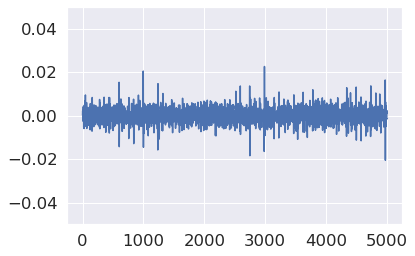

In [63]:
rdm = np.random.randint(0,raw.shape[0])

raw.iloc[rdm, :].plot(ylim=(-.05,.05))

In [81]:
ag.df.labels = ag.df.labels.apply(lambda x: 2)
ag.df.labels.value_counts()

2    478
Name: labels, dtype: int64

In [82]:
base_model = model
base_output = base_model.layers[-3].output
model_avgpool = Model(inputs=base_model.inputs, outputs=base_output)

In [82]:
preddph = model_avgpool.predict(valid_generator(X_test, y_test,
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-83-be9aa562949c>", line 6, in <module>
    steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1045, in predict
    use_multiprocessing=use_multiprocessing)
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1555, in predict_generator
    callbacks=callbacks)
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_generator.py", line 264, in model_iteration
    batch_outs = batch_function(*batch_data)
  File "/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/pytho

TypeError: object of type 'NoneType' has no len()

In [ ]:
predzap = model_avgpool.predict(valid_generator(ag.df.fnames.tolist(), ag.df.labels.tolist(),
                                     batch_size=traincf.batch_size,
                                     target_names=np.unique(y_test).tolist(),
                                     setting=traincf.setting,
                                     preprocessing_train_stats=''),
                     steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [ ]:
# sub = pd.DataFrame(np.round(predzap,decimals=2))
# sub.boxplot(showfliers=False)
# print(f"Zaprionus samples with prediction probability between 20% and 80%: {sub[sub[0].apply(lambda x: 0.35<x<0.65)].shape[0]}")
# print(f"Total Zaprionus samples: {sub.shape[0]}")

In [ ]:
# np.vstack((pred,pred2)).shape
# dph = pd.DataFrame({"pred1": preddph[:,0], "pred2": preddph[:,1], "y": y_test})
# zap = pd.DataFrame({"pred1": predzap[:,0], "pred2": predzap[:,1], "y": 2})

In [ ]:
twos = [2 for i in range(predzap.shape[0])]

features = np.vstack((preddph,predzap))
targets = np.hstack((np.array(y_test), np.array(twos)))

df = pd.DataFrame(features)
df['y'] = targets
# df = df.sample(4050)

# T-sne

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.iloc[:,:-1].values)

df_tsne = pd.DataFrame(tsne_results)
df_tsne['y'] = df.y
df_tsne.columns = ['first','second','y']

plt.figure(figsize=(16,10))
sns.scatterplot( x='first', 
                y='second',
                hue='y',
                palette=sns.color_palette("hls", 3),
                data=df_tsne,
                legend="full",
                alpha=0.2)
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_TSNE.png', format='png', bbox_inches='tight')

In [ ]:
import umap
import umap.plot
sns.set(font_scale=1.4)

mapper = umap.UMAP(random_state=seed).fit(df.iloc[:,:-1].values)

umap.plot.points(mapper, labels=df.y.values, width=1200, height=800, background='white', theme='fire')
plt.savefig(f'{TEMP_DATADIR}/result_TL{TL}_{data_setting}_{model_setting}_{splitting}_UMAP.png', format='png', bbox_inches='tight')

# mapper.embedding_

In [ ]:
import sklearn.neighbors

outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.005).fit_predict(df.iloc[:,:-1].values)

In [ ]:
plt.plot(outlier_scores)
# mapper.embedding_.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x = mapper.embedding_ 
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(x,df.y.values)
score = cross_val_score(lr, x, df.y.values, cv=5)
print("UMAP embeddings: \nCross_val_score: {},\nmean: \t\t{}".format(score, np.mean(score)))
print()
x = df_tsne.iloc[:,:-1].values #
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)
lr.fit(x,df.y.values)
score = cross_val_score(lr, x, df.y.values, cv=5)
print("T-sne embeddings: \nCross_val_score: {},\nmean: \t\t{}".format(score, np.mean(score)))

## Misclassification per dataset

In [ ]:
big = pd.DataFrame(X_test, columns=['fnames'])
big['dataset'] = pd.Series(X_test).apply(lambda x: x.split('/')[5])
big['species'] = pd.Series(X_test).apply(lambda x: x.split('/')[6])
big['y_test'] = y_test
big['y_pred'] = y_pred

allpreds = big[(big.species=='R') & (big.dataset=='Suzukii_RL')].shape[0]
corrpreds = big[(big.species=='R') & (big.dataset=='Suzukii_RL') & (big.y_pred == 1)].shape[0]
falsepreds = big[(big.species=='R') & (big.dataset=='Suzukii_RL') & (big.y_pred == 0)].shape[0]

print(f"suzukii-R all predictions: {allpreds}")
print(f"suzukii-R correct predictions: {corrpreds}")
print(f"suzukii-R false predictions: {falsepreds}")
print(f"{falsepreds/allpreds*100:.2f}%")

allpreds = big[(big.dataset=='Melanogaster_RL')].shape[0]
corrpreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 0)].shape[0]
falsepreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 1)].shape[0]

print(f"All melanogasters all predictions: {allpreds}")
print(f"All melanogasters correct predictions: {corrpreds}")
print(f"All melanogasters false predictions: {falsepreds}")
print(f"{falsepreds/allpreds*100:.2f}%")

In [ ]:
allpreds = big[(big.dataset=='Melanogaster_RL') & (big.species=='Z')].shape[0]
corrpreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 0) & (big.species=='Z')].shape[0]
falsepreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 1) & (big.species=='Z')].shape[0]

print(f"melanogaster-Z all predictions: {allpreds}")
print(f"melanogaster-Z correct predictions: {corrpreds}")
print(f"melanogaster-Z false predictions: {falsepreds}")
print(f"{falsepreds/allpreds*100:.2f}%")

In [ ]:
allpreds = big[(big.dataset=='Melanogaster_RL') & (big.species=='X')].shape[0]
corrpreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 0) & (big.species=='X')].shape[0]
falsepreds = big[(big.dataset=='Melanogaster_RL') & (big.y_pred == 1) & (big.species=='X')].shape[0]

print(f"melanogaster-X all predictions: {allpreds}")
print(f"melanogaster-X correct predictions: {corrpreds}")
print(f"melanogaster-X false predictions: {falsepreds}")
print(f"{falsepreds/allpreds*100:.2f}%")

In [ ]:
big.species.value_counts()

In [ ]:
len(y_test)